# Neural Nets with Keras

# Imports

In [1]:
# Workaround for making pydot work in current env
import os
PATH = os.getenv('PATH')
%env PATH=/Users/anto/miniconda3/envs/fastai/bin:$PATH

env: PATH=/Users/anto/miniconda3/envs/fastai/bin:/Users/anto/miniconda3/bin:/Users/anto/exec -l /bin/bash/google-cloud-sdk/bin:/Users/anto/miniconda3/bin:/usr/local/bin:/usr/bin:/bin:/usr/sbin:/sbin:/Library/TeX/texbin:/opt/X11/bin:/usr/local/git/bin


In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import sklearn
import sys
import tensorflow as tf
from tensorflow import keras  # tf.keras
import time
from functools import partial
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
print("python", sys.version)
for module in mpl, np, pd, sklearn, tf, keras:
    print(module.__name__, module.__version__)

python 3.7.2 (default, Dec 29 2018, 00:00:04) 
[Clang 4.0.1 (tags/RELEASE_401/final)]
matplotlib 3.0.3
numpy 1.16.2
pandas 0.24.2
sklearn 0.20.3
tensorflow 2.0.0-alpha0
tensorflow.python.keras.api._v2.keras 2.2.4-tf


In [4]:
assert sys.version_info >= (3, 6) # Python ≥3.6 required
assert tf.__version__ >= "2.0"    # TensorFlow ≥2.0 required

# Plot functions

In [5]:
def _default(def_dict, user_dict):
    if user_dict is None:
        user_dict = {}
    return {**def_dict, **user_dict}

def plot_learning_curves(history, title=None, axes=None, plot_kw=None):
    # This plot accepts both an History obj or
    # a dict like History.history
    if hasattr(history, 'history'):
        history = history.history
    if axes is None:
        fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharex=True)
    else:
        assert len(axes) == 2
        fig = axes[0].figure
    df = pd.DataFrame(history)
    plot_kw = _default(dict(marker='o', ms='4'), plot_kw)
    df[['loss', 'val_loss']].plot(ax=axes[0], **plot_kw)
    df[['accuracy', 'val_accuracy']].plot(ax=axes[1], **plot_kw)
    for ax in axes:
        ax.grid(True)
        ax.set_xlabel('Epochs')
        ax.set_xlim(-0.25, df.shape[0] - 0.75)
    y_th = 0.6
    frac = 0.3
    ymin = y_th if (df.accuracy > y_th).sum() > frac*df.shape[0] else 0
    axes[1].set_ylim(ymin, 1);
    axes[0].set_title('Loss')
    axes[1].set_title(f'Accuracy, max(val_acc) = {df.val_accuracy.max():.3f} @ {df.val_accuracy.idxmax()}')
    axes[1].axvline(df.val_accuracy.idxmax(), color='k', ls='--')
    if title is not None:
        fig.suptitle(title)
        
def plot_weights(history, axes=None, hist_kw=None):
    if axes is None:
        fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharex=True)
    else:
        assert len(axes) == 2
        fig = axes[0].figure
    model = history.model
    hist_kw = _default(dict(bins=80, histtype='step', density=True), hist_kw)
    for la in model.layers:
        params = la.get_weights()
        if len(params) == 1:
            w, b = params[0], np.array([])
        elif len(params) == 2:
            w, b = params
        else:
            continue
        axes[0].hist(w.ravel(), label=la.name, **hist_kw);
        axes[1].hist(b.ravel(), label=la.name, **hist_kw);
    axes[1].legend();
    axes[0].set_xlabel('weights')
    axes[1].set_xlabel('bias')
    for ax in axes: ax.grid(True)

# Load the Fashion MNIST dataset

Let's start by loading the fashion MNIST dataset. Keras has a number of functions to load popular datasets in `keras.datasets`. The dataset is already split for you between a training set and a test set, but it can be useful to split the training set further to have a validation set:

In [6]:
fashion_mnist = keras.datasets.fashion_mnist
(X_train_full, y_train_full), (X_test, y_test) = (
    fashion_mnist.load_data())
X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

The training set contains 55,000 grayscale images, each 28x28 pixels:

In [7]:
X_train.shape, X_valid.shape, X_test.shape

((55000, 28, 28), (5000, 28, 28), (10000, 28, 28))

You can plot an image using Matplotlib's `imshow()` function, with a `'binary'`
 color map:

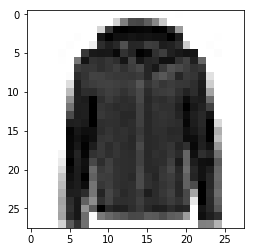

In [8]:
plt.imshow(X_train[0], cmap="binary");

The labels are the class IDs (represented as uint8), from 0 to 9:

In [9]:
y_train

array([4, 0, 7, ..., 3, 0, 5], dtype=uint8)

Here are the corresponding class names:

In [10]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

The validation set contains 5,000 images, and the test set contains 10,000 images:

In [11]:
X_valid.shape

(5000, 28, 28)

In [12]:
X_test.shape

(10000, 28, 28)

In [13]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float32).reshape(-1, 1)).reshape(-1, 28, 28)
X_valid_scaled = scaler.transform(X_valid.astype(np.float32).reshape(-1, 1)).reshape(-1, 28, 28)
X_test_scaled = scaler.transform(X_test.astype(np.float32).reshape(-1, 1)).reshape(-1, 28, 28)
X_test_scaled.shape, X_test_scaled.dtype

((10000, 28, 28), dtype('float32'))

# Build a classification neural network with Keras

In [28]:
def batch_gen(iterables, batch_size=32, shuffle=False):
    n = len(iterables[0])
    i = 0
    while True:
        if shuffle and i == 0: 
            iterables = [arr[np.random.permutation(n)] for arr in iterables]
        start = (i*batch_size) % n
        stop = start + batch_size  
        # NOTE: if stop > n last batch is < batch_size
        yield tuple(arr[start:stop] for arr in iterables)
        i += 1
        if i * batch_size >= n:
            i = 0  # end of an epoch

In [30]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28,28]),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(50, activation="relu"),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(10, activation="softmax"),
    ])
optim = keras.optimizers.Adam()
model.compile(optimizer=optim, 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# callbacks = [
#     LearningRateScheduler(partial(lr_range, init_lr=1e-4, points_per_dec=3)),
# ]

batch_size = 32
epochs = 4
#history = model.fit(X_train_scaled, y_train, epochs=epochs, batch_size=batch_size,
history = model.fit_generator(batch_gen([X_train_scaled, y_train], batch_size=batch_size),
                    steps_per_epoch=X_train.shape[0] // batch_size, epochs=epochs, workers=0, 
                    validation_data=(X_valid_scaled, y_valid),
                    #callbacks=callbacks,
                   )

Epoch 1/4
1718/1718 [==============================] - 8s 5ms/step - loss: 0.5252 - accuracy: 0.8106 - val_loss: 0.3824 - val_accuracy: 0.8666
Epoch 2/4
1718/1718 [==============================] - 6s 3ms/step - loss: 0.3963 - accuracy: 0.8561 - val_loss: 0.3554 - val_accuracy: 0.8718
Epoch 3/4
1718/1718 [==============================] - 6s 3ms/step - loss: 0.3565 - accuracy: 0.8686 - val_loss: 0.3551 - val_accuracy: 0.8720
Epoch 4/4
1718/1718 [==============================] - 6s 3ms/step - loss: 0.3325 - accuracy: 0.8780 - val_loss: 0.3383 - val_accuracy: 0.8760


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_4 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 100)               78500     
_________________________________________________________________
dense_13 (Dense)             (None, 50)                5050      
_________________________________________________________________
dropout_4 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_14 (Dense)             (None, 10)                510       
Total params: 84,060
Trainable params: 84,060
Non-trainable params: 0
_________________________________________________________________


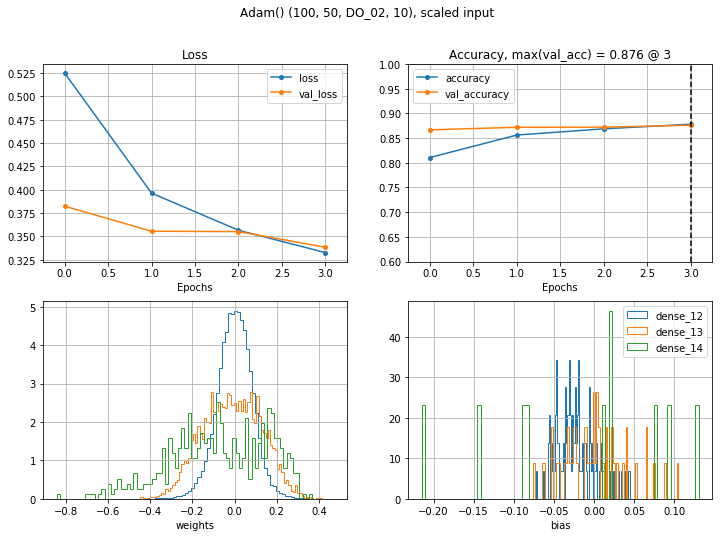

In [31]:
fig, Ax = plt.subplots(2, 2, figsize=(12, 8))
plot_learning_curves(history, axes=Ax[0])
plot_weights(history, axes=Ax[1])
plt.suptitle('Adam() (100, 50, DO_02, 10), scaled input');
model.summary()

In [22]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28,28]),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(50, activation="relu"),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(10, activation="softmax"),
    ])
optim = keras.optimizers.Adam()
model.compile(optimizer=optim, 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# callbacks = [
#     LearningRateScheduler(partial(lr_range, init_lr=1e-4, points_per_dec=3)),
# ]

batch_size = 32
epochs = 4
history = model.fit(X_train_scaled, y_train, epochs=epochs, batch_size=batch_size,
                    validation_data=(X_valid_scaled, y_valid),
                    #callbacks=callbacks,
                   )

Train on 55000 samples, validate on 5000 samples
Epoch 1/4
55000/55000 [==============================] - 5s 89us/sample - loss: 0.5348 - accuracy: 0.8068 - val_loss: 0.3906 - val_accuracy: 0.8604
Epoch 2/4
55000/55000 [==============================] - 5s 93us/sample - loss: 0.3990 - accuracy: 0.8543 - val_loss: 0.3522 - val_accuracy: 0.8764
Epoch 3/4
55000/55000 [==============================] - 4s 76us/sample - loss: 0.3661 - accuracy: 0.8652 - val_loss: 0.3335 - val_accuracy: 0.8770
Epoch 4/4
55000/55000 [==============================] - 4s 73us/sample - loss: 0.3385 - accuracy: 0.8760 - val_loss: 0.3362 - val_accuracy: 0.8752


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_3 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 100)               78500     
_________________________________________________________________
dense_10 (Dense)             (None, 50)                5050      
_________________________________________________________________
dropout_3 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 10)                510       
Total params: 84,060
Trainable params: 84,060
Non-trainable params: 0
_________________________________________________________________


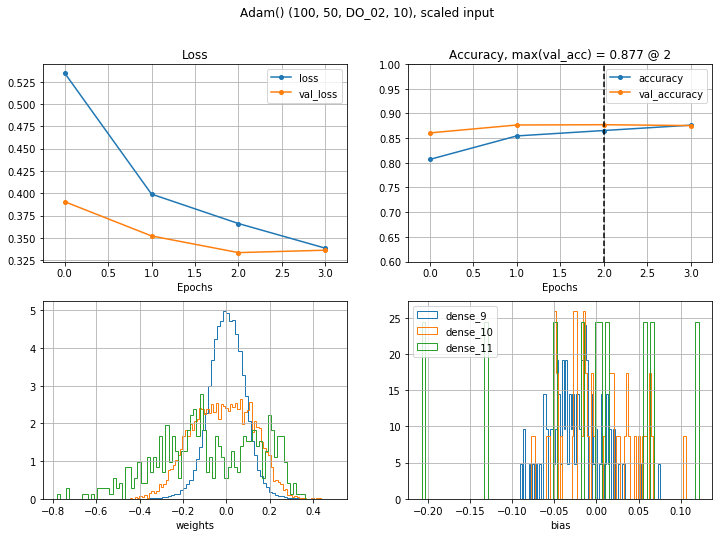

In [23]:
fig, Ax = plt.subplots(2, 2, figsize=(12, 8))
plot_learning_curves(history, axes=Ax[0])
plot_weights(history, axes=Ax[1])
plt.suptitle('Adam() (100, 50, DO_02, 10), scaled input');
model.summary()